### **MÓDULO 3: PUSH NOTIFICATIONS CON MODELOS NO LINEALES** 

Tras la creación de un baseline para el problema de negocio de las push notifications, aquí se explorará el uso de modelos no lineales. 

In [31]:
import pandas as pd 
import matplotlib.pyplot as plt 

def filter_data(df: pd.DataFrame, min_items: int = 5) -> pd.DataFrame:
    filtered_df = df.loc[df.groupby('order_id').filter(lambda x: (x.outcome == 1).sum() >= min_items).index]
    return filtered_df

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.sort_values(by='created_at')
    
    return df

data_path = '../data/feature_frame.csv' 
df = pd.read_csv(data_path) 
data = filter_data(df) 
data = format_dataframe(data)

def train_test_val_split(df: pd.DataFrame, train_size: float = 0.7, val_size: float = 0.2, test_size: float = 0.1
                         ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]: 
    n = len(df) 

    potential_train_rows = df[:int(n * train_size)]
    train_th_day = potential_train_rows['order_date'].iloc[-1]
    train_data = df[df['order_date'] <= train_th_day]
    y_train = train_data['outcome']
    x_train = train_data.drop(columns=['outcome'])

    potential_val_rows = df[int(n * train_size):int(n * (train_size + val_size))]
    val_th_day = potential_val_rows['order_date'].iloc[-1]
    val_data = df[(df['order_date'] > train_th_day) & (df['order_date'] <= val_th_day)]
    y_val = val_data['outcome']
    x_val = val_data.drop(columns=['outcome'])

    test_data = df[df['order_date'] > val_th_day]
    y_test = test_data['outcome']
    x_test = test_data.drop(columns=['outcome'])

    return x_train, x_val, x_test, y_train, y_val, y_test

def apply_common_transformations(df: pd.DataFrame) -> pd.DataFrame: 
    df.drop(columns=['variant_id', 'order_id', 'user_id', 'created_at', 'order_date'], inplace=True)

    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    categorical_cols = [col for col in df.select_dtypes(include='object').columns if col not in binary_cols]
    numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in binary_cols and col not in categorical_cols]

    return df, binary_cols, categorical_cols, numerical_cols 

x_train, x_val, x_test, y_train, y_val, y_test = train_test_val_split(data)

x_train, binary_cols, categorical_cols, numerical_cols = apply_common_transformations(x_train) 
x_val, _, _, _ = apply_common_transformations(x_val)
x_test, _, _, _ = apply_common_transformations(x_test)

x_train.drop(columns=categorical_cols, inplace=True)
x_val.drop(columns=categorical_cols, inplace=True)
x_test.drop(columns=categorical_cols, inplace=True) 

### 1. Random Forest 

El primero de los algoritmos que se probará será Random Forest. Ese algoritmo suele funcionar bien 'off the shelf'. En primer lugar, se probarán una serie de modelos Random Forest cuyas variaciones consistirán en el número de estimadores empleados. 

Training model with N=10 estimators...
Training model with N=20 estimators...
Training model with N=30 estimators...
Training model with N=40 estimators...
Training model with N=50 estimators...
Training model with N=60 estimators...
Training model with N=70 estimators...
Training model with N=80 estimators...
Training model with N=90 estimators...
Training model with N=100 estimators...


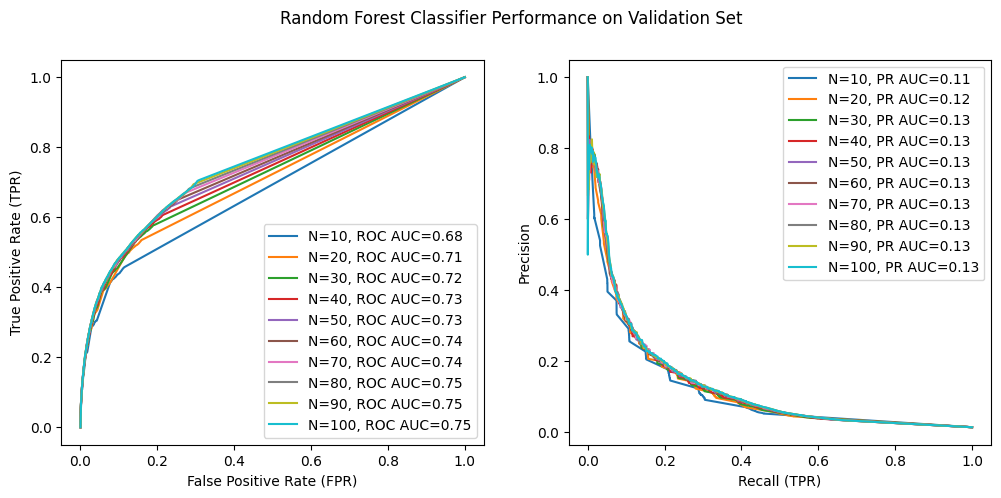

In [ ]:
import numpy as np 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, auc 

def create_pipeline(n: int) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', RandomForestClassifier(n_estimators=n, random_state=42))
    ])
    return model

N = np.arange(10, 101, 10) 
plt.figure(figsize=(12,5))
for n in N: 
    if n % 10 == 0: 
        print(f"Training model with N={n} estimators...")
    model = create_pipeline(n)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"N={n}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"N={n}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall (TPR)")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Random Forest Classifier Performance on Validation Set")
plt.show() 

En la exploración de los modelos lineales se observó que había variables cuya distribución se asemejaba a una delta de Dirac, y se vio que al eliminarlas el modelo no mostraba disminución en el rendimiento. Sin embargo, esto no tiene por qué ser cierto para Random Forest, pues no sabemos si estas variables son buenas para hacer los _splits_. A continuación se eliminarán dichas variables para comprobar si el rendimiento se ve afectado. 

Training model with N=10 estimators...
Training model with N=20 estimators...
Training model with N=30 estimators...
Training model with N=40 estimators...
Training model with N=50 estimators...
Training model with N=60 estimators...
Training model with N=70 estimators...
Training model with N=80 estimators...
Training model with N=90 estimators...
Training model with N=100 estimators...


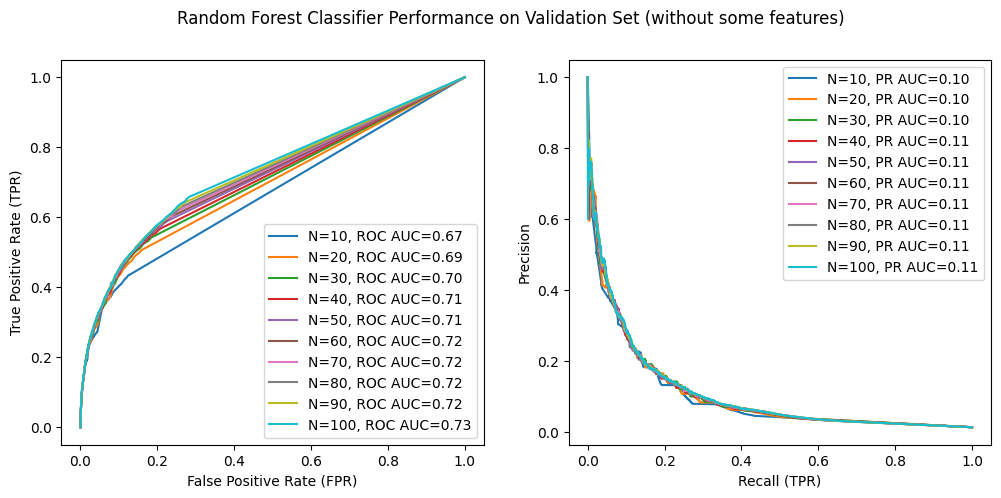

In [4]:
x_train_c = x_train.copy()
x_val_c = x_val.copy()
x_test_c = x_test.copy()

x_train_c.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                      'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_val_c.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                    'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)
x_test_c.drop(columns=['count_adults', 'count_children', 'count_pets', 'people_ex_baby', 
                     'days_since_purchase_variant_id', 'days_since_purchase_product_type'], inplace=True)


def create_pipeline(n: int) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', RandomForestClassifier(n_estimators=n, random_state=42))
    ])
    return model

N = np.arange(10, 101, 10) 
plt.figure(figsize=(12,5))
for n in N: 
    if n % 10 == 0: 
        print(f"Training model with N={n} estimators...")
    model = create_pipeline(n)
    model.fit(x_train_c, y_train)
    y_val_probs = model.predict_proba(x_val_c)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"N={n}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"N={n}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall (TPR)")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Random Forest Classifier Performance on Validation Set (without some features)")
plt.show() 

A la vista de los resultados, estas variables son importantes, pues se ve que su eliminación ha mermado parte del poder predictivo del modelo. 

### 2. Gradient Boosting Trees

Gradient Boosting Trees es ampliamente considerado el mejor algoritmo para tratar con datos tabulares. Para la experimentación con este modelo se realizará el mismo procedimiento que con Random Forest: encontrar el mejor parámetro `n_estimators`, determinar si ciertas variables son importantes o no y, por último, realizar una búsqueda de hiperparámetros. 

Training model with N=10 estimators...
Training model with N=20 estimators...
Training model with N=30 estimators...
Training model with N=40 estimators...
Training model with N=50 estimators...
Training model with N=60 estimators...
Training model with N=70 estimators...
Training model with N=80 estimators...
Training model with N=90 estimators...
Training model with N=100 estimators...


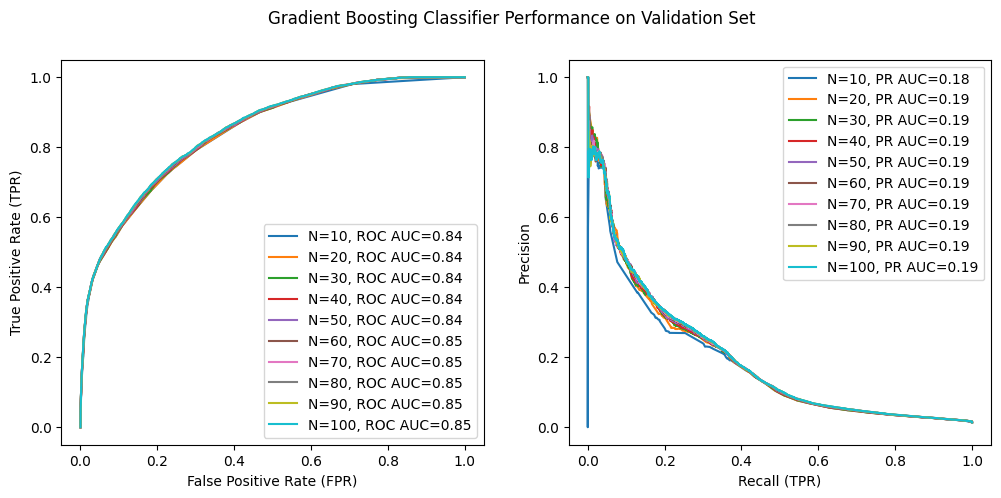

In [ ]:
import numpy as np 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.metrics import roc_curve, precision_recall_curve, auc 

def create_pipeline(n: int) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', GradientBoostingClassifier(n_estimators=n, random_state=42))
    ])
    return model

N = np.arange(10, 101, 10) 
plt.figure(figsize=(12,5))
for n in N: 
    if n % 10 == 0: 
        print(f"Training model with N={n} estimators...")
    model = create_pipeline(n)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"N={n}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"N={n}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall (TPR)")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Gradient Boosting Classifier Performance on Validation Set")
plt.show()

Los resultados obtenidos mejoran a los de Random Forest. En la gráfica de Precision-Recall se observa que el modelo con N=100 obtiene ligeramente mejor rendimiento que el resto. Empleando 100 estimadores, se probará a variar el _learning rate_. 

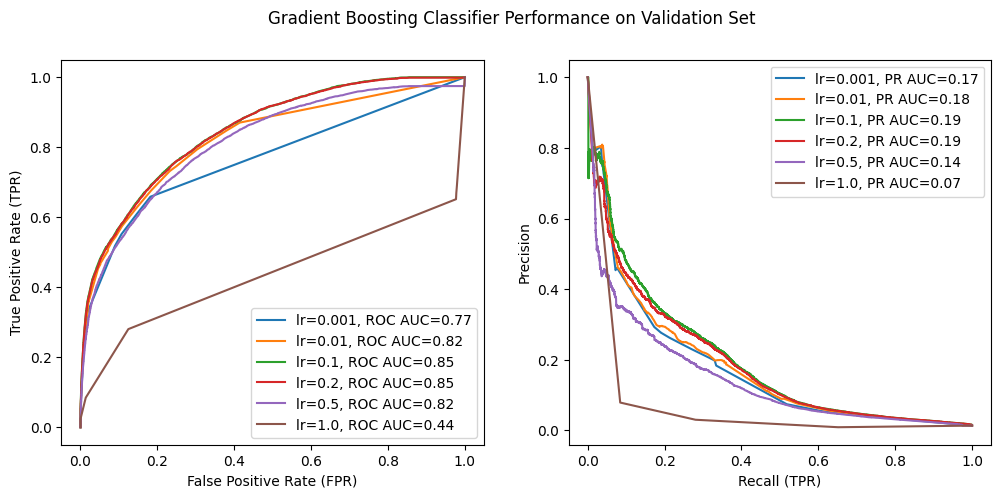

In [19]:
def create_pipeline(n: int, **kwargs) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', GradientBoostingClassifier(n_estimators=n, random_state=42, **kwargs))
    ])
    return model

LR = [0.001, 0.01, 0.1, 0.2, 0.5, 1.0]
plt.figure(figsize=(12,5))
for lr in LR: 
    model = create_pipeline(100, learning_rate=lr)
    model.fit(x_train, y_train)
    y_val_probs = model.predict_proba(x_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
    precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f"lr={lr}, ROC AUC={roc_auc:.2f}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f"lr={lr}, PR AUC={pr_auc:.2f}")
    plt.xlabel("Recall (TPR)")
    plt.ylabel("Precision")
    plt.legend()
plt.suptitle("Gradient Boosting Classifier Performance on Validation Set")
plt.show()

Los mejores modelos son aquellos con una tasa de aprendizaje de 0.1 o 0.2. 

### 3. XGBoost 

XGBoost es una implementación optimizada de Gradient Boosting Trees. 

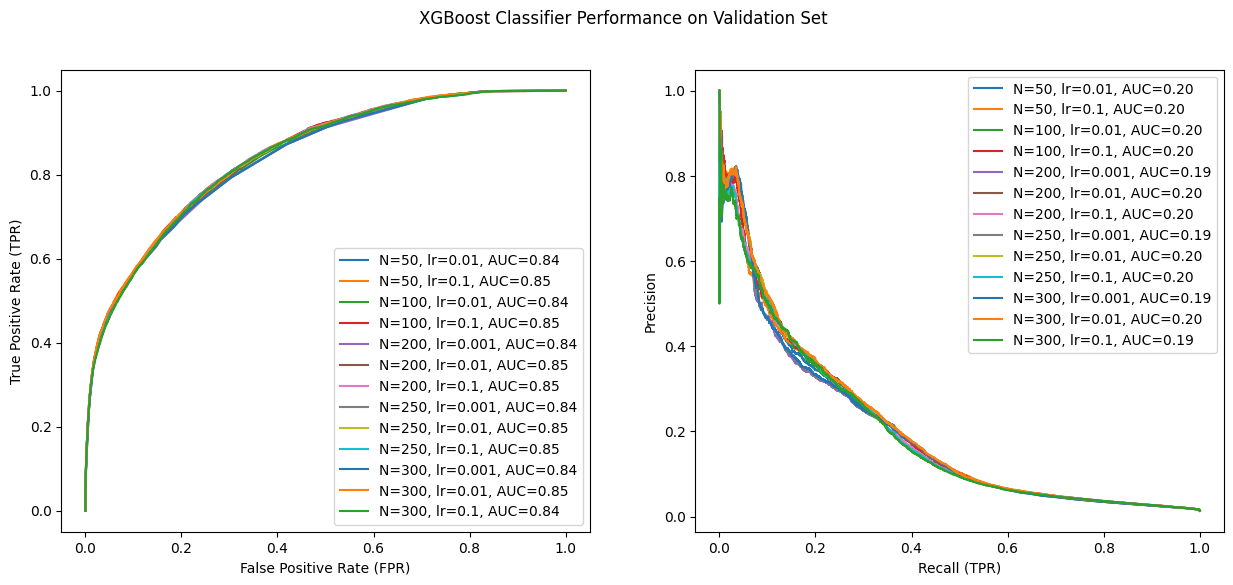

In [5]:
import numpy as np 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, auc 
import xgboost as xgb
from xgboost import XGBClassifier


xgb.set_config(verbosity=0)

def create_pipeline(**kwargs) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', XGBClassifier(random_state=42, **kwargs))
    ])
    return model

param_grid = {
    'classifier__n_estimators': [50, 100, 200, 250, 300],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.3, 0.6, 1.0],
}

plt.figure(figsize=(15,6))
for n in param_grid['classifier__n_estimators']:
    for lr in param_grid['classifier__learning_rate']:
        model = create_pipeline(n_estimators=n, learning_rate=lr, device='cuda')
        model.fit(x_train, y_train)
        y_val_probs = model.predict_proba(x_val)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
        precision, recall, pr_thresholds = precision_recall_curve(y_val, y_val_probs)
        roc_auc = auc(fpr, tpr)
        pr_auc = auc(recall, precision)
        if pr_auc < 0.19: 
            continue
        plt.subplot(1,2,1)
        plt.plot(fpr, tpr, label=f"N={n}, lr={lr}, AUC={roc_auc:.2f}")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(recall, precision, label=f"N={n}, lr={lr}, AUC={pr_auc:.2f}")
        plt.xlabel("Recall (TPR)")
        plt.ylabel("Precision")
        plt.legend()
plt.suptitle("XGBoost Classifier Performance on Validation Set")
plt.show()

Hay ciertos modelos que obtienen un PR-AUC de 0.20. Pese a que entre 0.19 y 0.20 no hay prácticamente diferencia, XGBoost está más optimizado, por lo que se preferirán estos modelos frente a las implementaciones de scikit-learn. 

Por último, se realizará una búsqueda de hiperparámetros para diferentes modelos XGBoost. 

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/ybiku/projects/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ybiku/projects/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/home/ybiku/projects/zrive/.venv/lib/python3.11/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type pr

[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=6, classifier__n_estimators=100; total time=  19.7s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=6, classifier__n_estimators=100; total time=  19.8s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=8, classifier__n_estimators=100; total time=  21.6s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=6, classifier__n_estimators=100; total time=  23.1s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=8, classifier__n_estimators=100; total time=  24.6s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=8, classifier__n_estimators=100; total time=  24.8s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=6, classifier__n_estimators=200; total time=  32.0s
[CV] END classifier__eta=0.001, classifier__gamma=0, classifier__max_depth=6, classifier__n_estimators=200; tot

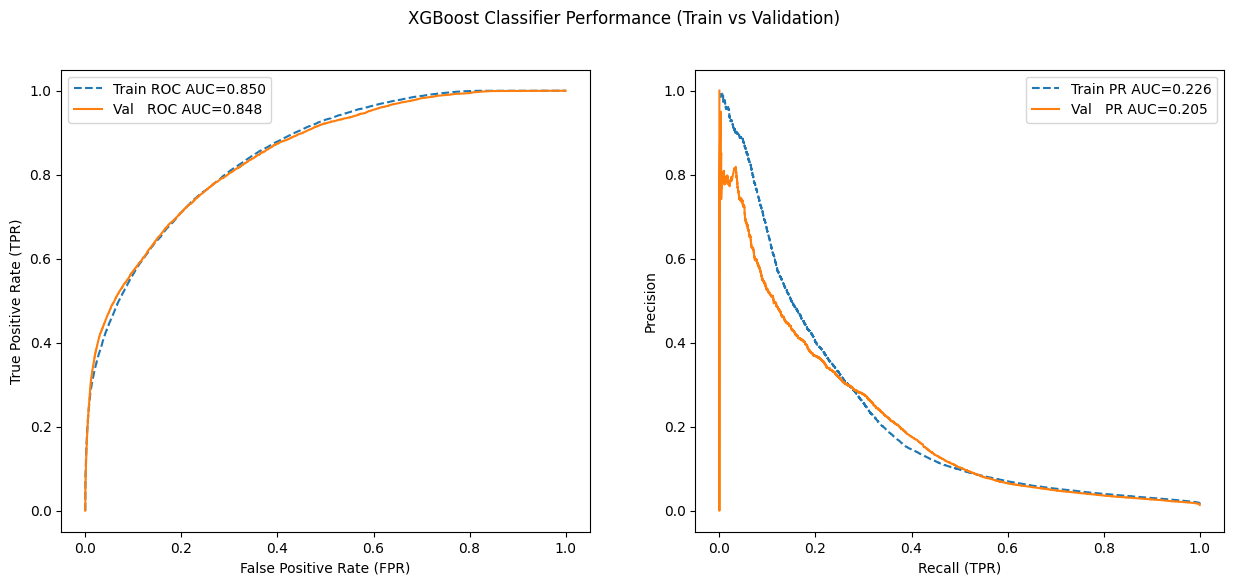

In [ ]:
import numpy as np 
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, auc 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
import warnings 

warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity=0)


def create_pipeline(**kwargs) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', XGBClassifier(random_state=42, device='cuda', **kwargs))
    ])
    return model

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__eta': [0.001, 0.01, 0.1, 0.2],
    'classifier__gamma': [0, 1, 5],
    'classifier__max_depth': [6, 8, 10]
}

grid_search = GridSearchCV(estimator=create_pipeline(), param_grid=param_grid, 
                           scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

plt.figure(figsize=(15,6))
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

best_model.fit(x_train, y_train)

y_val_probs = best_model.predict_proba(x_val)[:, 1]
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_probs)
roc_auc_val = auc(fpr_val, tpr_val)
pr_auc_val = auc(recall_val, precision_val)

y_train_probs = best_model.predict_proba(x_train)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)
pr_auc_train = auc(recall_train, precision_train)

print(f"Training ROC AUC: {roc_auc_train:.4f}, PR AUC: {pr_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}, PR AUC: {pr_auc_val:.4f}")

plt.subplot(1,2,1)
plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC={roc_auc_train:.3f}", color='tab:blue', linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val   ROC AUC={roc_auc_val:.3f}", color='tab:orange')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall_train, precision_train, label=f"Train PR AUC={pr_auc_train:.3f}", color='tab:blue', linestyle='--')
plt.plot(recall_val, precision_val, label=f"Val   PR AUC={pr_auc_val:.3f}", color='tab:orange')
plt.xlabel("Recall (TPR)")
plt.ylabel("Precision")
plt.legend()

plt.suptitle("XGBoost Classifier Performance (Train vs Validation)")
plt.show()


El mejor modelo encontrado tiene los siguientes hiperparámetros: 
- **n_estimators**: 300 
- **eta**: 0.01 
- **gamma**: 5 
- **max_depth**: 8 

Train ROC AUC: 0.8500, PR AUC: 0.2255
Val   ROC AUC: 0.8483, PR AUC: 0.2049
Test  ROC AUC: 0.8419, PR AUC: 0.2163


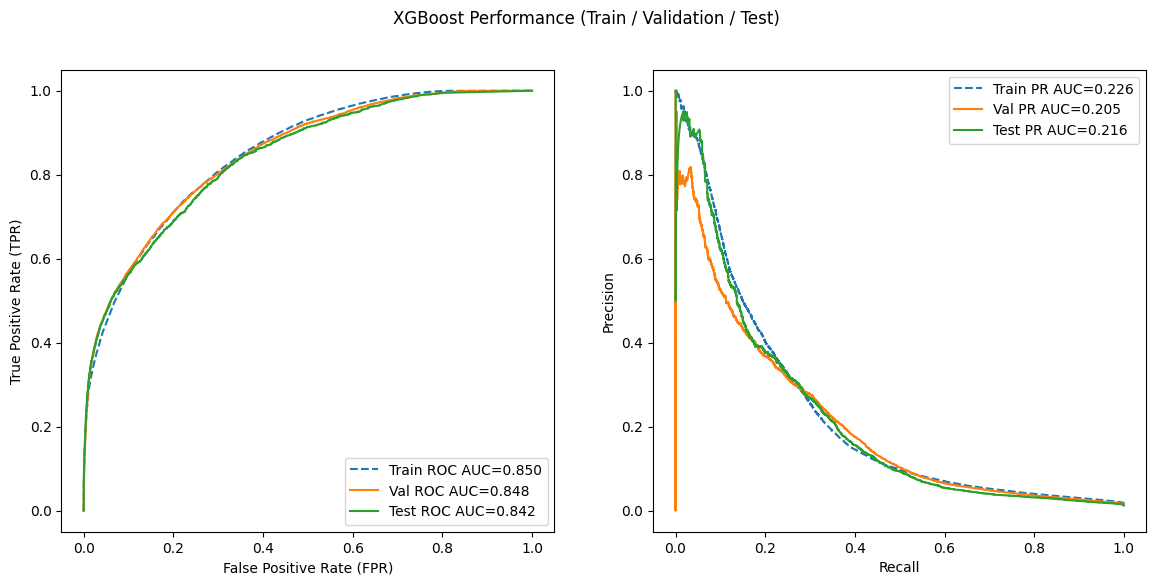

In [34]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, auc 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
import warnings 
import joblib 
import os 

warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity=0)

params = {
    'n_estimators': 300,
    'eta': 0.01,
    'gamma': 5,
    'max_depth': 8
}

def create_pipeline(**kwargs) -> Pipeline: 
    model = Pipeline(steps=[
        ('classifier', XGBClassifier(random_state=42, device='cuda', **kwargs))
    ])
    return model

best_model = XGBClassifier(random_state=42, device='cuda', **params)
best_model.fit(x_train, y_train)

y_train_probs = best_model.predict_proba(x_train)[:, 1]
y_val_probs = best_model.predict_proba(x_val)[:, 1]
y_test_probs = best_model.predict_proba(x_test)[:, 1]

fpr_tr, tpr_tr, _ = roc_curve(y_train, y_train_probs)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
fpr_te, tpr_te, _ = roc_curve(y_test, y_test_probs)
roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_te = auc(fpr_te, tpr_te)

prec_tr, rec_tr, _ = precision_recall_curve(y_train, y_train_probs)
prec_val, rec_val, _ = precision_recall_curve(y_val, y_val_probs)
prec_te, rec_te, _ = precision_recall_curve(y_test, y_test_probs)
pr_auc_tr = auc(rec_tr, prec_tr)
pr_auc_val = auc(rec_val, prec_val)
pr_auc_te = auc(rec_te, prec_te)

print(f"Train ROC AUC: {roc_auc_tr:.4f}, PR AUC: {pr_auc_tr:.4f}")
print(f"Val   ROC AUC: {roc_auc_val:.4f}, PR AUC: {pr_auc_val:.4f}")
print(f"Test  ROC AUC: {roc_auc_te:.4f}, PR AUC: {pr_auc_te:.4f}")

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(fpr_tr, tpr_tr, label=f"Train ROC AUC={roc_auc_tr:.3f}", linestyle='--')
plt.plot(fpr_val, tpr_val, label=f"Val ROC AUC={roc_auc_val:.3f}")
plt.plot(fpr_te, tpr_te, label=f"Test ROC AUC={roc_auc_te:.3f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec_tr, prec_tr, label=f"Train PR AUC={pr_auc_tr:.3f}", linestyle='--')
plt.plot(rec_val, prec_val, label=f"Val PR AUC={pr_auc_val:.3f}")
plt.plot(rec_te, prec_te, label=f"Test PR AUC={pr_auc_te:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.suptitle("XGBoost Performance (Train / Validation / Test)")
plt.show()